In [41]:
import xarray as xa
import math
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

# Mapping degree day accumulation per time period $\Delta t$.

## Step 0: Determine mean $T_0$ threshold from seasonality data set. 

*(not implemented)*

## Step 1: Load data & calculate number of degree days. 

Set geographic boundaries for the analysis: 

In [59]:
minLon, maxLon = 190, 330
minLat, maxLat = 0, 90


Load the weather dataset (here just 1991-2000):

In [60]:
weather = xa.open_dataset("weatherdata/HadGHCND_TXTN_acts_1991-2000_15102015.nc", decode_times=False);
weather

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 96, time: 3652)
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 ...
  * longitude  (longitude) float32 0.0 3.75 7.5 11.25 15.0 18.75 22.5 26.25 ...
  * time       (time) float32 727199.0 727200.0 727201.0 727202.0 727203.0 ...
Data variables:
    tmax       (time, latitude, longitude) float32 nan nan nan nan nan nan ...
    tmin       (time, latitude, longitude) float32 nan nan nan nan nan nan ...

Define georegion and plot a sanity check for projection:

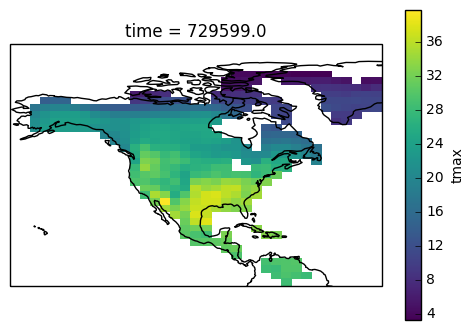

In [67]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

georegion = weather.sel(longitude=slice(minLon, maxLon), latitude=slice(maxLat, minLat))
georegion.tmax.sel(time=729599).plot()

Next we'll implement the degree days function, implemented [here](https://github.com/lbuckley/ICBseasonality/blob/master/DDFunctions.R) in R. 

In [ ]:
## row is a Numpy Series representing a single row from the Dataset:
##    tmin: temperature minimum value
##    tmax: temperature max value
## ldt: lower developmental threshold.
def degreeDays(row, ldt): 
    tmin = float(row['tmin'])
    tmax = float(row['tmax'])
    ldt  = float(ldt)
    
    if (math.isnan(tmin) or math.isnan(tmax)): return 0
    
    degreeDays = 0.0
    
    if (tmin >= ldt): # temperature entirely above ldt
        degreeDays = (tmax + tmin)/2-ldt
    
    if (tmin < ldt and tmax > ldt):
        alpha = (tmax-tmin)/2
        theta1 = math.asin(((ldt - (tmax+tmin))/alpha)*math.pi/180.0)
        degreeDays = 1/math.pi*(((tmax+tmin)/2-ldt)*(math.pi/2-theta1)+alpha*math.cos(theta1))
        
        if(degreeDays < 0):
            degreeDays = 0
        
    if (tmax <= ldt):
        degreeDays = 0
        
    return degreeDays


Convert georegion from xarray DataArrays to numpy DataFrame for `apply()` and compute `degreeDays` function on all rows. 

In [ ]:
georegion_df = georegion.to_dataframe()
dd = georegion_df.apply(degreeDays, axis=1, ldt=10)

Recombine back into original `Dataset` and plot. 

In [65]:
da = dd.to_xarray()
wx_dd = xa.merge([georegion, {'dd':da}])


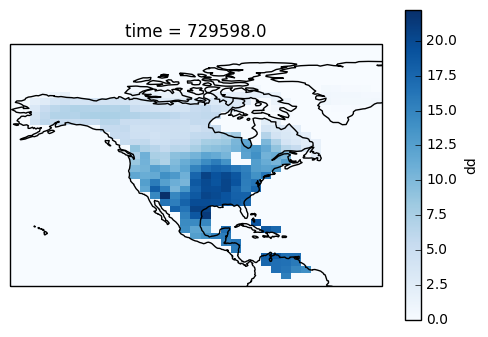

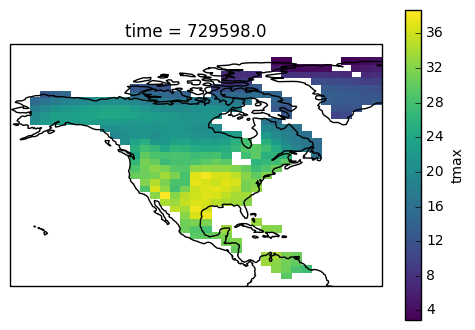

In [66]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()


wx_dd.dd.sel(time=729598).plot(cmap=plt.cm.Blues)
plt.show()
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()

wx_dd.tmax.sel(time=729598).plot()

## Step 2: Aggregate degree days per $\Delta t$ (here $\Delta t = \textrm{1 year}$.)
Use [`xarray.DataArray.cumsum()`](https://xarray.pydata.org/en/latest/generated/xarray.DataArray.cumsum.html)

## Step 3: Calculate phenology of first generation
Goal: Determine the date per time interval $\Delta t$ when aggregate degree days cumulative sum reaches threshold. 

## Step 4: Calculate number of generations possible per time interval $\Delta t$.